In [10]:
# Remove any broken installs
!pip -q uninstall -y Box2D box2d-py gymnasium pygame

# System dep FIRST (needed to build box2d-py)
!apt-get -y update >/dev/null
!apt-get -y install swig >/dev/null

# Basic Python tooling + a missing IPython dep Colab warned about
!pip -q install -U pip setuptools wheel "jedi>=0.16"


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [1]:
!pip install gymnasium numpy matplotlib tqdm

In [2]:
!pip install swig

In [3]:
!pip install gymnasium[box2d]

  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pygame-2.6.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
Using cached pygame-2.6.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (14.0 MB)
  error: subprocess-exited-with-error
  
  × Building wheel for box2d-py (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> No available output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
Failed to build box2d-py
error: failed-wheel-build-for-install

× Failed to build installable wheels for some pyproject.toml based projects
╰─> box2d-py


In [7]:
# Pygame first avoids some resolver pinning hiccups
!pip -q install "pygame>=2.5.2"

# Install the Box2D extra (pulls box2d-py) AFTER swig is present
#!pip -q install "gymnasium[box2d]"

# RL libs
!pip -q install "stable-baselines3[extra]" sb3-contrib tensorboard


In [8]:
import gymnasium as gym, Box2D, pygame, stable_baselines3 as sb3
print("Gymnasium:", gym.__version__)
print("SB3:", sb3.__version__)
print("Box2D OK:", hasattr(Box2D, "__version__"))
print("CarRacing make:", gym.make("CarRacing-v3", continuous=True))


ModuleNotFoundError: No module named 'Box2D'

In [9]:
import sys, torch, gymnasium as gym, stable_baselines3 as sb3
print("Python:", sys.version.split()[0])
print("Gymnasium:", gym.__version__, "SB3:", sb3.__version__, "PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())


Python: 3.12.12
Gymnasium: 1.2.2 SB3: 2.7.0 PyTorch: 2.8.0+cu126
CUDA available: True


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
import gymnasium as gym
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecTransposeImage, VecFrameStack

ENV_ID = "CarRacing-v3"

# Vectorized env + wrappers for pixel-based CNN policies
venv = make_vec_env(
    ENV_ID, n_envs=4, seed=0,
    env_kwargs=dict(continuous=True, lap_complete_percent=0.95)  # continuous controls for SAC
)
venv = VecTransposeImage(venv)        # HWC → CHW for PyTorch
venv = VecFrameStack(venv, n_stack=4) # 4-frame stack for short memory from pixels

model = SAC("CnnPolicy", venv, verbose=1, tensorboard_log="./tb/sac_car")
model.learn(total_timesteps=20000)  # start small; increase to 1e6+ when you're ready
model.save("sac_car")
venv.close()


Using cuda device


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 221.20GB > 86.86GB
  warnings.warn(


Logging to ./tb/sac_car/SAC_1


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -35.4    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 44       |
|    time_elapsed    | 90       |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | -8.08    |
|    critic_loss     | 0.237    |
|    ent_coef        | 0.747    |
|    ent_coef_loss   | -1.48    |
|    learning_rate   | 0.0003   |
|    n_updates       | 974      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -35.5    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 44       |
|    time_elapsed    | 181      |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | -13.2    |
|    critic_loss     | 0.505    |
|    ent_coef 

In [ ]:
import torch
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecTransposeImage, VecFrameStack

ENV_ID = "CarRacing-v3"

eval_env = make_vec_env(
    ENV_ID, n_envs=1, seed=123,
    env_kwargs=dict(continuous=True, lap_complete_percent=0.95, render_mode=None)
)
eval_env = VecTransposeImage(eval_env)
eval_env = VecFrameStack(eval_env, n_stack=4)

device = "cuda" if torch.cuda.is_available() else "cpu"

# NOTE: pass device=... to load (and bind env here)
model = SAC.load(
    "sac_car",
    env=eval_env,
    device=device,
    custom_objects={"buffer_size": 100_000}  # shrink buffer for eval-only
)

MAX_STEPS = 3000
obs = eval_env.reset()
ep_reward = 0.0

with torch.inference_mode():
    for t in range(MAX_STEPS):
        action, _ = model.predict(obs, deterministic=True)
        obs, rewards, dones, infos = eval_env.step(action)
        ep_reward += float(rewards[0])
        if dones[0]:
            break

print("SAC episode reward:", round(ep_reward, 2),
      "| finished:", bool(dones[0]), "| steps:", t+1)
eval_env.close()


SAC episode reward: -34.78 | finished: True | steps: 1000


In [ ]:
# === VIDEO of one episode (deterministic) — FIXED ===
import glob, torch
from IPython.display import HTML
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecTransposeImage, VecFrameStack, VecVideoRecorder

ENV_ID = "CarRacing-v3"
MODEL_PATH = "sac_car"  # or "./models/sac_best/best_model.zip"
device = "cuda" if torch.cuda.is_available() else "cpu"

# Build eval env with SAME wrappers as training, but enable frame rendering for video:
eval_env = make_vec_env(
    ENV_ID,
    n_envs=1,
    seed=999,
    env_kwargs=dict(
        continuous=True,
        lap_complete_percent=0.95,
        render_mode="rgb_array"   # <-- REQUIRED for VecVideoRecorder
    ),
)
eval_env = VecTransposeImage(eval_env)        # HWC -> CHW
eval_env = VecFrameStack(eval_env, n_stack=4) # 4 stacked frames -> 12 channels

# Attach a video recorder (records the very first episode)
video_env = VecVideoRecorder(
    eval_env,
    video_folder="videos",
    record_video_trigger=lambda step: step == 0,
    video_length=10_000,             # max frames to record
    name_prefix="sac_carracing"
)

# Load model and bind to the recorder env (also shrink buffer for eval-only)
model = SAC.load(
    MODEL_PATH,
    env=video_env,
    device=device,
    custom_objects={"buffer_size": 100_000}
)

# Roll one episode deterministically
obs = video_env.reset()
while True:
    action, _ = model.predict(obs, deterministic=True)
    obs, rewards, dones, infos = video_env.step(action)
    if dones[0]:
        break

# Close and display
video_env.close()

# Show the latest MP4 inline
vids = sorted(glob.glob("videos/*.mp4"))
print("Saved video:", vids[-1])
HTML(f'<video controls width="640"><source src="{vids[-1]}" type="video/mp4"></video>')


/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"


Moviepy - Building video /content/videos/sac_carracing-step-0-to-step-10000.mp4.
Moviepy - Writing video /content/videos/sac_carracing-step-0-to-step-10000.mp4



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Moviepy - Done !
Moviepy - video ready /content/videos/sac_carracing-step-0-to-step-10000.mp4
Saved video: videos/sac_carracing-step-0-to-step-10000.mp4


In [ ]:
from google.colab import drive; drive.mount('/content/drive')
!cp -v videos/*.mp4 /content/drive/MyDrive/


Mounted at /content/drive
'videos/sac_carracing-step-0-to-step-10000.mp4' -> '/content/drive/MyDrive/sac_carracing-step-0-to-step-10000.mp4'


,seed,reward,steps
0,1001,-32.692308,1000
1,1002,-23.636366,1000
2,1003,-33.333335,1000
3,1004,0.671138,1000
4,1005,-7.975460,1000


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Mean reward: -19.39326609224081 ± 15.183383182566889


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


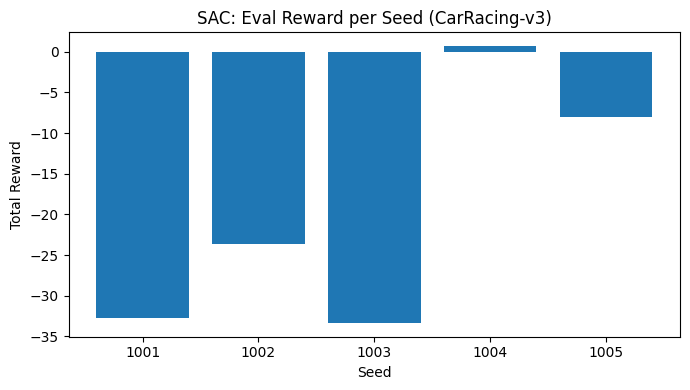

Saved: sac_eval_rewards.png and sac_eval_rewards.csv


In [ ]:
# === BASIC GRAPH of eval rewards across seeds ===
import torch, numpy as np, pandas as pd, matplotlib.pyplot as plt
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecTransposeImage, VecFrameStack

ENV_ID   = "CarRacing-v3"
MODEL    = "sac_car"  # or "models/sac_best/best_model.zip"
SEEDS    = [1001, 1002, 1003, 1004, 1005]
MAX_STEPS = 3000

def make_eval_env(seed):
    env = make_vec_env(
        ENV_ID, n_envs=1, seed=seed,
        env_kwargs=dict(continuous=True, lap_complete_percent=0.95, render_mode=None)
    )
    env = VecTransposeImage(env)
    env = VecFrameStack(env, n_stack=4)
    return env

rows = []
for s in SEEDS:
    env = make_eval_env(s)
    model = SAC.load(MODEL, env=env, device="cuda" if torch.cuda.is_available() else "cpu",
                     custom_objects={"buffer_size": 100_000})
    obs = env.reset()
    total, steps = 0.0, 0
    for t in range(MAX_STEPS):
        a, _ = model.predict(obs, deterministic=True)
        obs, r, dones, infos = env.step(a)
        total += float(r[0]); steps += 1
        if dones[0]:
            break
    rows.append({"seed": s, "reward": total, "steps": steps})
    env.close()

df = pd.DataFrame(rows)
display(df)
print("Mean reward:", df["reward"].mean(), "±", df["reward"].std())

# Bar chart
plt.figure(figsize=(7,4))
plt.bar(df["seed"].astype(str), df["reward"])
plt.title("SAC: Eval Reward per Seed (CarRacing-v3)")
plt.xlabel("Seed"); plt.ylabel("Total Reward")
plt.tight_layout()
plt.savefig("sac_eval_rewards.png", dpi=150)
plt.show()

# Save CSV too
df.to_csv("sac_eval_rewards.csv", index=False)
print("Saved: sac_eval_rewards.png and sac_eval_rewards.csv")


LONGER RUNS:TRAINING + EVALUATION CHECKPOINTS

In [ ]:
import torch
import gymnasium as gym
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecTransposeImage, VecFrameStack, VecMonitor
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback, StopTrainingOnNoModelImprovement

ENV_ID = "CarRacing-v3"

# ------- TRAIN ENV (parallel) -------
train_env = make_vec_env(
    ENV_ID, n_envs=4, seed=0,
    env_kwargs=dict(continuous=True, lap_complete_percent=0.95, render_mode=None)
)
train_env = VecTransposeImage(train_env)
train_env = VecFrameStack(train_env, n_stack=4)
train_env = VecMonitor(train_env)  # episode stats in infos

# ------- EVAL ENV (single) -------
eval_env = make_vec_env(
    ENV_ID, n_envs=1, seed=123,
    env_kwargs=dict(continuous=True, lap_complete_percent=0.95, render_mode=None)
)
eval_env = VecTransposeImage(eval_env)
eval_env = VecFrameStack(eval_env, n_stack=4)
eval_env = VecMonitor(eval_env)

# ------- CALLBACKS -------
stop_cb = StopTrainingOnNoModelImprovement(
    max_no_improvement_evals=10, min_evals=10, verbose=1
)
eval_cb = EvalCallback(
    eval_env,
    best_model_save_path="./models/sac_best",
    log_path="./logs/sac_eval",
    eval_freq=100_000,            # evaluate every 100k steps
    n_eval_episodes=3,
    deterministic=True,
    callback_after_eval=stop_cb
)
ckpt_cb = CheckpointCallback(save_freq=200_000, save_path="./models/sac_ckpts", name_prefix="sac")

# ------- MODEL -------
model = SAC(
    "CnnPolicy",
    train_env,
    verbose=1,
    tensorboard_log="./tb/sac_car",
    learning_rate=3e-4,
    buffer_size=300_000,          # smaller than default to reduce RAM
    batch_size=256,
    tau=0.005,
    gamma=0.99,
    train_freq=1,
    gradient_steps=1,
    ent_coef="auto"
)

model.learn(total_timesteps=1_000_000, callback=[eval_cb, ckpt_cb])
model.save("sac_car_1M")
train_env.close(); eval_env.close()


In [ ]:
import torch, numpy as np
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecTransposeImage, VecFrameStack, VecMonitor

ENV_ID = "CarRacing-v3"
MODEL_PATH = "./models/sac_best/best_model.zip"  # or "sac_car_1M.zip"

eval_env = make_vec_env(
    ENV_ID, n_envs=1, seed=999,
    env_kwargs=dict(continuous=True, lap_complete_percent=0.95, render_mode=None)
)
eval_env = VecTransposeImage(eval_env)
eval_env = VecFrameStack(eval_env, n_stack=4)
eval_env = VecMonitor(eval_env)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = SAC.load(MODEL_PATH, env=eval_env, device=device, custom_objects={"buffer_size": 100_000})

MAX_STEPS = 3000
obs = eval_env.reset()
ep_reward = 0.0
terminated_cause = "unknown"

with torch.inference_mode():
    for t in range(MAX_STEPS):
        action, _ = model.predict(obs, deterministic=True)
        obs, rewards, dones, infos = eval_env.step(action)
        ep_reward += float(rewards[0])
        if dones[0]:
            # SB3/Monitor puts 'episode' summary in info when episode ends
            info = infos[0]
            if info.get("terminal_observation") is not None:
                # TimeLimit truncation path often fills this; also check key:
                terminated_cause = "time_limit" if info.get("TimeLimit.truncated", False) else "terminated"
            else:
                terminated_cause = "terminated"
            break

print(f"SAC episode reward: {ep_reward:.2f} | steps: {t+1} | end: {terminated_cause}")
eval_env.close()
